In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

# Small area population estimation
__Data__
* Water use data
* Census Block Group (CBG) level population data from ACS
* Building information from PLUTO

__Process__
* Data cleaning and integration - water use, pluto, and CBG population
* Regression modeling to compute the weighted values (the water consumption per capita of each housing type of a given CBG)
* Building level population estimation
* Validation
* Building level population estimation of office buildings

## 1. Data cleaning and integration
### 1) Water data

In [2]:
df_14 = pd.read_csv('../data/DSNYResidentialFinal_2014.csv', header = 1, dtype = {'BBL':str})
df_14.columns = ['BBL', '14Jan', '14Apr', '14Jul', '14Oct']
df_15 = pd.read_csv('../data/DSNYResidentialFinal_2015.csv', header = 1, dtype = {'BBL':str})
df_15.columns = ['BBL', '15Jan', '15Apr', '15Jul', '15Oct']
df_16 = pd.read_csv('../data/DSNYResidentialFinal_2016.csv', header = 1, dtype = {'BBL':str})
df_16.columns = ['BBL', '16Jan', '16Apr', '16Jul', '16Oct']
df_17 = pd.read_csv('../data/DSNYResidentialFinal_2017.csv', header = 1, dtype = {'BBL':str})
df_17 = df_17.drop('Unnamed: 3', axis=1)
df_17.columns = ['BBL', '17Jan', '17Apr']

# Merge data 2014 - 2017
dfs = [df_14, df_15, df_16, df_17]
df = reduce(lambda left,right: pd.merge(left,right,on='BBL', how = 'outer'), dfs)
print len(df)

# if you want to operate on multiple columns, put them in a list like so:
cols = df.columns.tolist()[1:]

# pass them to df.replace(), specifying each char and it's replacement:
df[cols] = df[cols].replace({',': ''}, regex=True)
df[cols] = df[cols].astype(float)

df.head(2)

734879


,BBL,14Jan,14Apr,14Jul,14Oct,15Jan,15Apr,15Jul,15Oct,16Jan,16Apr,16Jul,16Oct,17Jan,17Apr
0,1000070038,2195.0,2607.0,4364.0,4258.0,3253.0,3002.0,4726.0,3758.0,3637.0,3494.0,5980.0,6067.0,7415.0,4848.0
1,1000087501,18500.0,650.0,5200.0,1800.0,1700.0,850.0,8550.0,1550.0,1700.0,1400.0,5250.0,2950.0,4250.0,6150.0


### 2) PLUTO data
* 2016 version is used

In [3]:
#2016 pluto
mn = pd.read_csv('../data/pluto16/MN.csv', dtype={'BBL':str})
bx = pd.read_csv('../data/pluto16/BX.csv', dtype={'BBL':str})
bk = pd.read_csv('../data/pluto16/BK.csv', dtype={'BBL':str})
qn = pd.read_csv('../data/pluto16/QN.csv', dtype={'BBL':str})
si = pd.read_csv('../data/pluto16/SI.csv', dtype={'BBL':str})
boros = [mn, bx, bk, qn, si]

nyc = pd.concat(boros)

#### Categorize residential building type 
Residential building (One family, Two family, Walkup, Elevator apartment, Condominium (Residential area dominated), Multiple use residence, NYCHA)
* One family dwellings: ['BldgClass'].str[0]=='A'
* Two family dwellings: ['BldgClass'].str[0]=='B'
* Walkup apartment: ['BldgClass'].str[0]=='C'
* Elevator apartment: ['BldgClass'].str[0]=='D' excluding ['OwnerName']=='NYC HOUSING AUTHORITY'
* Condominium: ['BldgClass'].str[0]=='R' & ['ResArea']>0
* Multiple use residence: ['BldgClass'].str[0]=='S'
* NYCHA Housing: ['OwnerName']=='NYC HOUSING AUTHORITY'

Office building
* ['BldgClss'].str(0) == 'O'

In [4]:
# Add columns to mark building type
nyc['BldgType'] = 'Others'
nyc['BldgType'][nyc['BldgClass'].str[0]=='A'] = 'A'
nyc['BldgType'][nyc['BldgClass'].str[0]=='B'] = 'B'
nyc['BldgType'][nyc['BldgClass'].str[0]=='C']= 'C'
nyc['BldgType'][(nyc['BldgClass'].str[0]=='D') & (nyc['OwnerName']!='NYC HOUSING AUTHORITY')] = 'D'
nyc['BldgType'][(nyc['BldgClass'].str[0]=='R') & (nyc['ResArea']>0)] = 'R'
nyc['BldgType'][nyc['BldgClass'].str[0]=='S'] = 'S'
nyc['BldgType'][nyc['OwnerName']=='NYC HOUSING AUTHORITY'] = 'P'
nyc['BldgType'][nyc['BldgClass'].str[0] == 'O'] = 'O'

nyc = nyc[['BBL', 'BldgType', 'BldgClass', 'LandUse', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 
               'RetailArea', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'AssessTot', 'YearBuilt']]

### 3) Merge datasets Water use and PLUTO

In [5]:
nyc['BBL'] = nyc['BBL'].astype(str)
nyc['BBL'] = nyc['BBL'].str[0:10]
df['BBL'] = df['BBL'].astype(str)
data = pd.merge(df, nyc, how='left', on='BBL')
data = data.drop_duplicates()
#data = data.dropna()
print len(data)

734879


In [6]:
data.head(2)

,BBL,14Jan,14Apr,14Jul,14Oct,15Jan,15Apr,15Jul,15Oct,16Jan,...,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,AssessTot,YearBuilt
0,1000070038,2195.0,2607.0,4364.0,4258.0,3253.0,3002.0,4726.0,3758.0,3637.0,...,7485.0,3012.0,4473.0,1491.0,1521.0,5.0,3.0,5.0,535090.0,1900.0
1,1000087501,18500.0,650.0,5200.0,1800.0,1700.0,850.0,8550.0,1550.0,1700.0,...,169061.0,42641.0,126420.0,0.0,42641.0,19.0,97.0,98.0,16020450.0,1985.0


#### Normalizing water consumption data
* Average water conumption per sqft

In [7]:
# Considering only 2016 water consumption to match data coverage with other data sources (PLUTO and ACS)
data['AVG_Water'] = data[['16Jan', 
                          '16Apr', '16Jul', '16Oct']].mean(axis=1)

data['AVG_Water_sqft'] = data['AVG_Water']/data['ResArea']
data['AVG_Water_sqft'][data['BldgType']=='O'] = data['AVG_Water']/data['OfficeArea']
data['AVG_Water_sqft'][data['BldgType']=='S'] = data['AVG_Water']/(data['BldgArea'])

data['AVG_Water_pu'] = data['AVG_Water']/data['UnitsRes']
data['AVG_Water_pu'][data['BldgType']=='S'] = data['AVG_Water']/(data['UnitsTotal'])
data['AVG_Water_pu'][data['BldgType']=='O'] = data['AVG_Water']/(data['UnitsTotal'] - data['UnitsRes'])

In [8]:
data.head(2)

,BBL,14Jan,14Apr,14Jul,14Oct,15Jan,15Apr,15Jul,15Oct,16Jan,...,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,AssessTot,YearBuilt,AVG_Water,AVG_Water_sqft,AVG_Water_pu
0,1000070038,2195.0,2607.0,4364.0,4258.0,3253.0,3002.0,4726.0,3758.0,3637.0,...,1491.0,1521.0,5.0,3.0,5.0,535090.0,1900.0,4794.5,0.640548,958.900000
1,1000087501,18500.0,650.0,5200.0,1800.0,1700.0,850.0,8550.0,1550.0,1700.0,...,0.0,42641.0,19.0,97.0,98.0,16020450.0,1985.0,2825.0,0.022346,29.123711


In [9]:
# Water consumption data coverage
print "Onefamily with water data: ", len(data[(data['BldgType']=='A') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='A'])
print "Twofamily with water data: ", len(data[(data['BldgType']=='B') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='B'])
print "Walkup with water data: ", len(data[(data['BldgType']=='C') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='C'])
print "Elevator apt with water data: ", len(data[(data['BldgType']=='D') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='D'])
print "Condominium with water data: ", len(data[(data['BldgType']=='R') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='R'])
print "Multipleuse residence building with water data: ", len(data[(data['BldgType']=='S') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='S'])
print "NYCHA with water data: ", len(data[(data['BldgType']=='P') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='P'])

print "Office building with water data: ", len(data[(data['BldgType']=='O') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='O'])
print "Other BBLs with water data: ", len(data[(data['BldgType']=='Others') & (data['AVG_Water']>0)]), "/",len(data[data['BldgType']=='Others'])

Onefamily with water data:  297602 / 306626
Twofamily with water data:  234316 / 242067
Walkup with water data:  123255 / 129331
Elevator apt with water data:  11589 / 12575
Condominium with water data:  4317 / 4544
Multipleuse residence building with water data:  29889 / 31641
NYCHA with water data:  492 / 547
Office building with water data:  20 / 27
Other BBLs with water data:  266 / 639


#### Excluding BBLs without water data or building area and keeping only residential buildings

In [10]:
# Drop '0' building area and Others type
# To consider residential buildings and office buildings
# Drop BBLs without water consumption data
print "Original BBLs: ", len(data)
data = data[(data['ResArea']>0) | (data['OfficeArea']>0)]
data = data[data['BldgType']!= 'Others']
data = data[np.isfinite(data['AVG_Water'])]
data = data[np.isfinite(data['AVG_Water_sqft'])]
data = data[np.isfinite(data['AVG_Water_pu'])]
data = data[data['BldgType']!='O']
print "Proper BBLs: ",len(data)

Original BBLs:  734879
Proper BBLs:  710008


In [11]:
data[['BldgArea', 'ResArea', 'OfficeArea', 'AVG_Water', 'AVG_Water_sqft', 'AVG_Water_pu']].describe()

,BldgArea,ResArea,OfficeArea,AVG_Water,AVG_Water_sqft,AVG_Water_pu
count,7.100080e+05,7.100080e+05,710008.000000,7.100080e+05,710008.000000,710008.000000
mean,4.482114e+03,4.246599e+03,28.936125,7.671536e+02,0.140382,157.746788
std,3.371999e+04,3.144558e+04,2130.959225,9.910957e+03,0.509599,367.962462
min,2.000000e+02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.421000e+03,1.380000e+03,0.000000,1.227500e+02,0.069046,80.000000
50%,1.980000e+03,1.900000e+03,0.000000,2.082500e+02,0.110000,127.250000
75%,2.800000e+03,2.640000e+03,0.000000,3.662500e+02,0.169000,193.500000
max,1.354011e+07,1.321140e+07,969910.000000,3.621898e+06,316.375000,240360.500000


In [12]:
bldgtype = ['A', 'B', 'C', 'D', 'R', 'S', 'P', 'O']

for t in bldgtype:
    if t == 'O':
        break
    else:
        print "----- ", t, " -----"
        print data[data['BldgType']== t][['AVG_Water', 'AVG_Water_sqft', 'AVG_Water_pu']].describe()

-----  A  -----
           AVG_Water  AVG_Water_sqft   AVG_Water_pu
count  301655.000000   301655.000000  301655.000000
mean      171.035101        0.118542     170.460682
std       506.684370        0.737717     496.337419
min         0.000000        0.000000       0.000000
25%        90.250000        0.060417      90.250000
50%       142.000000        0.096999     142.000000
75%       210.250000        0.146104     210.250000
max    240360.500000      316.375000  240360.500000
-----  B  -----
           AVG_Water  AVG_Water_sqft   AVG_Water_pu
count  236975.000000   236975.000000  236975.000000
mean      272.443488        0.134560     136.221744
std       280.117735        0.189128     140.058868
min         0.000000        0.000000       0.000000
25%       147.250000        0.071674      73.625000
50%       229.750000        0.112319     114.875000
75%       343.250000        0.168996     171.625000
max     66962.250000       63.202862   33481.125000
-----  C  -----
           AVG_W

Text(0,0.5,u'Cubic feet')

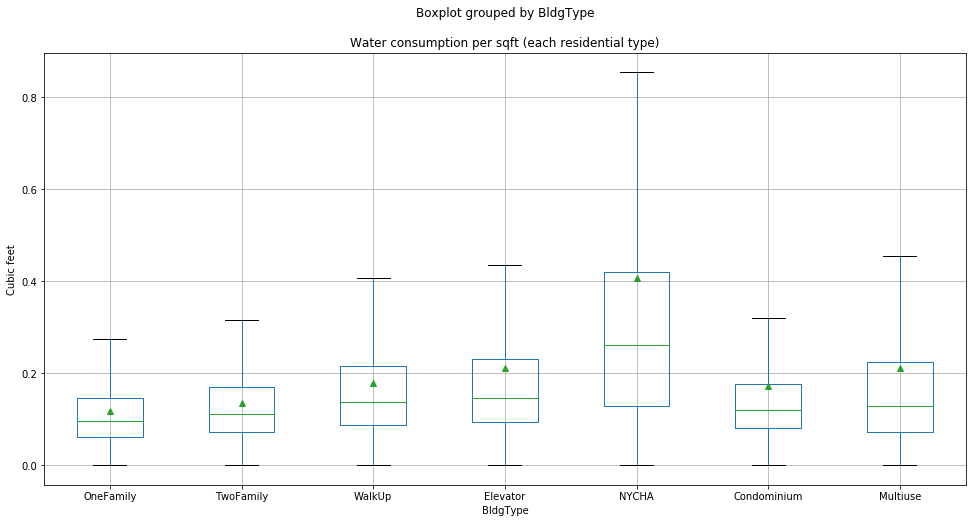

In [13]:
data.boxplot(column='AVG_Water_sqft', by='BldgType', figsize=(16,8),  sym='',showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['OneFamily', 'TwoFamily', 'WalkUp', 'Elevator', 'NYCHA', 'Condominium', 'Multiuse'])
plt.title("Water consumption per sqft (each residential type)")
plt.ylabel("Cubic feet")

### 4) Aggregating dataset to CBG level 
* BBL level water use and building information data to CBG level
* Merge with CBG level population data from ACS (2016-5year estimate is used)

In [14]:
# Keep only relevant columns
data = data[['BBL', 'AVG_Water', 'BldgType', 'ResArea']]

# create new columns based on different residential building types
data['W_A'] = 0
data['W_A'][data['BldgType']=='A'] = data['AVG_Water']
data['W_B'] = 0
data['W_B'][data['BldgType']=='B'] = data['AVG_Water']
data['W_C'] = 0
data['W_C'][data['BldgType']=='C'] = data['AVG_Water']
data['W_D'] = 0
data['W_D'][data['BldgType']=='D'] = data['AVG_Water']
data['W_R'] = 0
data['W_R'][data['BldgType']=='R'] = data['AVG_Water']
data['W_S'] = 0
data['W_S'][data['BldgType']=='S'] = data['AVG_Water']
data['W_P'] = 0
data['W_P'][data['BldgType']=='P'] = data['AVG_Water']

data['RA_A'] = 0
data['RA_A'][data['BldgType']=='A'] = data['ResArea']
data['RA_B'] = 0
data['RA_B'][data['BldgType']=='B'] = data['ResArea']
data['RA_C'] = 0
data['RA_C'][data['BldgType']=='C'] = data['ResArea']
data['RA_D'] = 0
data['RA_D'][data['BldgType']=='D'] = data['ResArea']
data['RA_R'] = 0
data['RA_R'][data['BldgType']=='R'] = data['ResArea']
data['RA_S'] = 0
data['RA_S'][data['BldgType']=='S'] = data['ResArea']
data['RA_P'] = 0
data['RA_P'][data['BldgType']=='P'] = data['ResArea']

data.head(2)

,BBL,AVG_Water,BldgType,ResArea,W_A,W_B,W_C,W_D,W_R,W_S,W_P,RA_A,RA_B,RA_C,RA_D,RA_R,RA_S,RA_P
0,1000070038,4794.5,S,4473.0,0.0,0.0,0.0,0.0,0.0,4794.5,0.0,0,0,0,0,0,4473,0
1,1000087501,2825.0,R,126420.0,0.0,0.0,0.0,0.0,2825.0,0.0,0.0,0,0,0,0,126420,0,0


In [15]:
# Load BBL-CBG joined file
bbl_cbg = pd.read_csv('../data/bbl_cbg.csv', dtype={'BBL':str, 'GEOID':str})
bbl_cbg['BBL'] = bbl_cbg['BBL'].str[:10]
bbl_cbg = bbl_cbg[['BBL', 'AFFGEOID', 'GEOID']]

# Merge water consumption data above + bbl-cbg id
bbl_cbg = pd.merge(bbl_cbg, data, how='left', on='BBL')
bbl_cbg = bbl_cbg.dropna()

In [16]:
bbl_cbg.head(2)

,BBL,AFFGEOID,GEOID,AVG_Water,BldgType,ResArea,W_A,W_B,W_C,W_D,W_R,W_S,W_P,RA_A,RA_B,RA_C,RA_D,RA_R,RA_S,RA_P
0,5080500076,1500000US360850248001,360850248001,116.75,A,1472.0,116.75,0.0,0.0,0.0,0.0,0.0,0.0,1472.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5079230035,1500000US360850244022,360850244022,404.00,B,3475.0,0.00,404.0,0.0,0.0,0.0,0.0,0.0,0.0,3475.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Group by CBG - Calculating CBG level water consumption data
data_cbg = bbl_cbg.groupby('AFFGEOID').sum()
data_cbg['AFFGEOID'] = data_cbg.index
data_cbg = data_cbg.reset_index(drop=True)
data_cbg.head(2)

,AVG_Water,ResArea,W_A,W_B,W_C,W_D,W_R,W_S,W_P,RA_A,RA_B,RA_C,RA_D,RA_R,RA_S,RA_P,AFFGEOID
0,55441.50,408031.0,14664.75,21921.75,18442.50,0.0,0.0,412.50,0.0,124176.0,167788.0,113667.0,0.0,0.0,2400.0,0.0,1500000US360050002001
1,77212.75,595413.0,13735.75,38040.00,24358.25,0.0,0.0,1078.75,0.0,104662.0,310873.0,175503.0,0.0,0.0,4375.0,0.0,1500000US360050002002


In [18]:
# Load and merge ACS population data
pop = pd.read_csv('../data/ACS_16_5YR_B01001_with_ann.csv', header=1, skiprows=0)
pop['AFFGEOID'] = pop['Id']
pop['pop'] = pop['Estimate; Total:']
pop = pop[['AFFGEOID', 'pop']]

# Merge
df = pd.merge(data_cbg, pop, how='left', on='AFFGEOID')

full_cbg = pd.read_csv('../data/CBG_2016_NYC.csv')
full_cbg = full_cbg[['GEOID', 'GEOID_Data']]
df['GEOID_Data'] = df['AFFGEOID'].str[7:]
df['GEOID_Data'] = '15000'+df['GEOID_Data']
full_cbg_df = pd.merge(full_cbg, df, how='left', on='GEOID_Data')
full_cbg_df = full_cbg_df.fillna(0)


full_cbg_df['W_A'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0
full_cbg_df['W_B'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0
full_cbg_df['W_C'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0
full_cbg_df['W_D'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0
full_cbg_df['W_R'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0
full_cbg_df['W_S'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0
full_cbg_df['W_P'][(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)] = 0

full_cbg_df[(full_cbg_df['pop']==0) & (full_cbg_df['AVG_Water']>0)].head()

,GEOID,GEOID_Data,AVG_Water,ResArea,W_A,W_B,W_C,W_D,W_R,W_S,W_P,RA_A,RA_B,RA_C,RA_D,RA_R,RA_S,RA_P,AFFGEOID,pop
766,360610297000,15000US360610297000,11300.00,142000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142000.0,0.0,0.0,0.0,1500000US360610297000,0.0
796,360810383021,15000US360810383021,80678.25,548688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13692.0,5406.0,161378.0,368212.0,0.0,0.0,0.0,1500000US360810383021,0.0
1126,360470177001,15000US360470177001,34064.00,213287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78783.0,134504.0,0.0,0.0,0.0,1500000US360470177001,0.0
1177,360470154001,15000US360470154001,13381.50,114273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9716.0,35127.0,69430.0,0.0,0.0,0.0,0.0,1500000US360470154001,0.0
2030,360470407001,15000US360470407001,4027.00,40912.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1718.0,20257.0,18937.0,0.0,0.0,0.0,0.0,1500000US360470407001,0.0


In [19]:
print len(full_cbg_df)

6493


## 2. Regression modeling to compute the weighted values (the water consumption per capita of each housing type of a given CBG)

In [20]:
import statsmodels.formula.api as sm

# without intercept

X = full_cbg_df[['W_A','W_B','W_C','W_D','W_R','W_S','W_P']]
Y = full_cbg_df['pop']

result = sm.OLS(Y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     3192.
Date:                Tue, 12 Jun 2018   Prob (F-statistic):               0.00
Time:                        17:20:30   Log-Likelihood:                -51548.
No. Observations:                6493   AIC:                         1.031e+05
Df Residuals:                    6486   BIC:                         1.032e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
W_A            0.0186      0.001     30.836      0.000       0.017       0.020
W_B            0.0302      0.001     43.984      0.000       0.029       0.032
W_C            0.0149      0.000     58.402      0.000       0.014       0.015
W_D            0.0053      0.000     49.594      0.000       0.005       0.005
W_R            0.0022      0.000     11.986      0.000       0.002       0.003
W_S            0.0237      0.001     17.077      0.000       0.021       0.026
W_P            0.0023      0.000     16.226      0.000       0.002       0.003
==============================================================================
Omnibus:                     2229.715   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           346574.107
Skew:                          -0.523   Prob(JB):                         0.00
Kurtosis:                      38.776   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Building level population estimation - residential buildings

In [21]:
df = full_cbg_df

### Coefficients of regression model (OLS)
POP = W_A * betaA + W_B * betaB + ... W_P * betaP
* betaA = 0.0186
* betaB = 0.0302
* betaC = 0.0149
* betaD = 0.0053
* betaR = 0.0022
* betaS = 0.0237
* betaP = 0.0023	

In [22]:
# x = unit (P/W)
# e.g. 
# A type (pop/water) = 0.0110239x
# In other words, A type (water/pop) = 1/0.0110239x
df['x'] = df['pop']/(df['W_A']*0.0186 + df['W_B']*0.0302 + df['W_C']*0.0149 + df['W_D']*0.0053 +
                    df['W_R']*0.0022 + df['W_S']*0.0237 + df['W_P']*0.0023)

df['Wpc_A'] = 1 / (df['x']*0.0186)
df['Wpc_B'] = 1 / (df['x']*0.0302)
df['Wpc_C'] = 1 / (df['x']*0.0149)
df['Wpc_D'] = 1 / (df['x']*0.0053)
df['Wpc_R'] = 1 / (df['x']*0.0022)
df['Wpc_S'] = 1 / (df['x']*0.0237)
df['Wpc_P'] = 1 / (df['x']*0.0023)

In [23]:
# Simple homogenous Wpc
df['Wpc_simple'] = df['AVG_Water'] / df['pop']
df['Wpc_simple'] = df['Wpc_simple'].replace(np.nan, 0)

In [24]:
df_wpc_cbg = df[['GEOID', 'GEOID_Data', 'Wpc_A', 'Wpc_B', 'Wpc_C', 'Wpc_D', 'Wpc_R', 'Wpc_S', 'Wpc_P', 'Wpc_simple']]

In [25]:
# Load BBL level water consumption data to compute BBl level pop
df_bbl = pd.read_csv('../data/water_bbl_withcbgid.csv')
df_bbl = pd.merge(df_bbl, df_wpc_cbg, how='left', on='GEOID')

# Simple BBL level population

df_bbl['pop_simple'] = df_bbl['AVG_Water'] / df_bbl['Wpc_simple']
df_bbl['pop_simple'] = df_bbl['pop_simple'].replace(np.nan, 0)

In [26]:
df_bbl = df_bbl[df_bbl['BBL']!=4160010002]
df_bbl = df_bbl[df_bbl['BBL']!=4025990094]

In [27]:
# Compute BBL level population
# Population = Water consumption / WaterPC

df_bbl['pop_est'] = df_bbl['W_A']/df_bbl['Wpc_A']
df_bbl['pop_est'][df_bbl['BldgType']=='B'] = df_bbl['W_B']/df_bbl['Wpc_B']
df_bbl['pop_est'][df_bbl['BldgType']=='C'] = df_bbl['W_C']/df_bbl['Wpc_C']
df_bbl['pop_est'][df_bbl['BldgType']=='D'] = df_bbl['W_D']/df_bbl['Wpc_D']
df_bbl['pop_est'][df_bbl['BldgType']=='R'] = df_bbl['W_R']/df_bbl['Wpc_R']
df_bbl['pop_est'][df_bbl['BldgType']=='S'] = df_bbl['W_S']/df_bbl['Wpc_S']
df_bbl['pop_est'][df_bbl['BldgType']=='P'] = df_bbl['W_P']/df_bbl['Wpc_P']

df_bbl['pop_simple_r'] = df_bbl['pop_simple'].round(0)
df_bbl['pop_est_r'] = df_bbl['pop_est'].round(0)

print "Average occupants of One family housing: ", df_bbl['pop_est'][df_bbl['BldgType']=='A'].mean()
print "Average occupants of Two family housing: ", df_bbl['pop_est'][df_bbl['BldgType']=='B'].mean()
print "Average occupants of Walk up apartment: ", df_bbl['pop_est'][df_bbl['BldgType']=='C'].mean()
print "Average occupants of Elevator apartment: ", df_bbl['pop_est'][df_bbl['BldgType']=='D'].mean()
print "Average occupants of Condo: ", df_bbl['pop_est'][df_bbl['BldgType']=='R'].mean()
print "Average occupants of Mixed-use walk up: ", df_bbl['pop_est'][df_bbl['BldgType']=='S'].mean()
print "Average occupants of NYCHA housing: ", df_bbl['pop_est'][df_bbl['BldgType']=='P'].mean()

Average occupants of One family housing:  3.38012614214
Average occupants of Two family housing:  8.67669486447
Average occupants of Walk up apartment:  21.1132420063
Average occupants of Elevator apartment:  135.262154623
Average occupants of Condo:  31.5481375112
Average occupants of Mixed-use walk up:  17.7243942131
Average occupants of NYCHA housing:  387.20140952


In [28]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='A'].head(10)

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
0,5080500076,A,1472.0,119.500000,2.272125,2.0,1.803280,2.0
3,5079290070,A,1718.0,201.071429,3.327472,3.0,2.612894,3.0
4,5079290066,A,622.0,140.714286,2.328640,2.0,1.828561,2.0
5,5080050172,A,2850.0,42.642857,0.810794,1.0,0.643490,1.0
7,5079640010,A,1216.0,186.000000,3.078060,3.0,2.417043,2.0
9,5079260087,A,1226.0,211.857143,3.505962,4.0,2.753052,3.0
12,5079270075,A,3500.0,175.357143,2.901934,3.0,2.278740,2.0
13,5080500050,A,2922.0,212.500000,4.040389,4.0,3.206669,3.0
14,5079440023,A,1416.0,125.714286,2.080409,2.0,1.633639,2.0
15,5079320021,A,1500.0,204.000000,3.375936,3.0,2.650950,3.0


In [29]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='B'].head()

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
1,5079230035,B,3475.0,225.214286,4.128437,4.0,4.878231,5.0
2,5079450043,B,1852.0,131.571429,2.177337,2.0,2.776048,3.0
6,5079390001,B,4100.0,307.428571,5.087545,5.0,6.486488,6.0
8,5079400078,B,1824.0,275.000000,4.550895,5.0,5.802272,6.0
10,5079280096,B,2700.0,321.428571,5.319227,5.0,6.781876,7.0


In [30]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='C'].head()

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
1793,5080470025,C,10650.0,1364.285714,25.939978,26.0,16.492019,16.0
1846,5080470075,C,3654.0,348.928571,6.634387,7.0,4.217985,4.0
1871,5080260038,C,4650.0,583.571429,11.095792,11.0,7.054440,7.0
1951,5080260042,C,2000.0,339.000000,6.445609,6.0,4.097965,4.0
1972,5080470023,C,12025.0,837.142857,15.917096,16.0,10.119710,10.0


In [31]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='D'].head()

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
49571,5009550075,D,115563.0,7840.071429,416.704526,417.0,416.704526,417.0
54293,5012720011,D,526554.0,60321.428571,1256.738298,1257.0,630.265538,630.0
63539,5007520001,D,69143.0,7064.285714,173.380891,173.0,43.298965,43.0
71063,5010350019,D,53438.0,6057.142857,150.085438,150.0,37.176909,37.0
73543,5039830001,D,352800.0,34689.428571,526.022742,526.0,526.022742,526.0


In [32]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='R'].head()

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
2981,5078607502,R,45577.0,1305.500000,25.086466,25.0,2.634773,3.0
2988,5078607501,R,39394.0,51.214286,0.984133,1.0,0.103361,0.0
3242,5078607503,R,26942.0,1834.428571,35.250348,35.0,3.702261,4.0
9002,5070487502,R,25750.0,83.785714,3.042592,3.0,0.291006,0.0
9046,5070407501,R,55424.0,1492.214286,37.627052,38.0,5.472836,5.0


In [33]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='S'].head()

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
559,5080490007,S,1500.0,186.857143,3.552826,4.0,3.592860,4.0
1131,5079140004,S,950.0,253.785714,4.199826,4.0,4.202173,4.0
1452,5079140001,S,2400.0,391.785714,6.483547,6.0,6.487171,6.0
1812,5080010051,S,1400.0,150.857143,2.868337,3.0,2.900658,3.0
1830,5080260008,S,1728.0,426.800000,8.115003,8.0,8.206444,8.0


In [34]:
df_bbl[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_simple','pop_simple_r','pop_est', 'pop_est_r']][df_bbl['BldgType']=='P'].head()

,BBL,BldgType,ResArea,AVG_Water,pop_simple,pop_simple_r,pop_est,pop_est_r
54534,5012450001,P,312400.0,177937.642857,778.374173,778.0,443.837293,444.0
54652,5012480200,P,222300.0,167730.714286,733.724769,734.0,418.377725,418.0
64433,5007060001,P,490000.0,154694.142857,1036.251693,1036.0,1036.251693,1036.0
72071,5001960001,P,543818.0,332314.357143,1585.228055,1585.0,1521.467337,1521.0
78581,5035320500,P,448500.0,195851.428571,1824.687994,1825.0,680.157204,680.0


## 4. Validation

In [35]:
# Load LL84 data 
ll = pd.read_csv('../data/LL84_2015_bbl_eui_flagged.csv')
ll_bedroom = pd.DataFrame()
ll_bedroom['BBL'] = ll['new_bbl'].astype(str)
ll_bedroom['Occupancy'] = ll['Occupancy']
ll_bedroom['Multifamily Housing - Gross Floor Area (ft_2)'] = ll['Multifamily Housing - Gross Floor Area (ft_2)']
ll_bedroom['Multifamily Housing - Number of Bedrooms'] = ll['Multifamily Housing - Number of Bedrooms']
ll_bedroom = ll_bedroom[ll_bedroom['Multifamily Housing - Gross Floor Area (ft_2)']>0]
ll_bedroom.columns = [['BBL', 'Occupancy', 'GFA','Bedrooms']]

ll_bedroom.head()

,BBL,Occupancy,GFA,Bedrooms
14,4020860040,100,503000.0,500.00
17,3056460036,100,65500.0,91.70
22,2054017501,90,50934.0,71.31
31,1011860025,100,172225.0,241.12
32,1010080026,100,53837.0,75.37


In [36]:
print "Validation available multi-unit residential buildings :", len(ll_bedroom['BBL'])

Validation available multi-unit residential buildings : 10120


In [37]:
df_bbl = df_bbl[['BBL', 'BldgType', 'pop_est', 'pop_est_r', 'ResArea', 'AVG_Water']]
df_bbl['BBL'] = df_bbl['BBL'].astype(str)
df_bbl.head(2)

,BBL,BldgType,pop_est,pop_est_r,ResArea,AVG_Water
0,5080500076,A,1.803280,2.0,1472.0,119.500000
1,5079230035,B,4.878231,5.0,3475.0,225.214286


In [38]:
ll_bedroom.head()

,BBL,Occupancy,GFA,Bedrooms
14,4020860040,100,503000.0,500.00
17,3056460036,100,65500.0,91.70
22,2054017501,90,50934.0,71.31
31,1011860025,100,172225.0,241.12
32,1010080026,100,53837.0,75.37


In [39]:
df_bbl.to_csv('../data/pop_est.csv', index=False)
ll_bedroom.to_csv('../data/val_llbedroom.csv', index=False)

In [40]:
d1 = pd.read_csv('../data/pop_est.csv', dtype={'BBL':str})
d2 = pd.read_csv('../data/val_llbedroom.csv',dtype={'BBL':str})

In [41]:
d1.head(2)

,BBL,BldgType,pop_est,pop_est_r,ResArea,AVG_Water
0,5080500076,A,1.803280,2.0,1472.0,119.500000
1,5079230035,B,4.878231,5.0,3475.0,225.214286


In [42]:
d2.head(2)

,BBL,Occupancy,GFA,Bedrooms
0,4020860040,100,503000.0,500.0
1,3056460036,100,65500.0,91.7


In [43]:
result = pd.merge(d2, d1, how='left', on='BBL')
result = result.drop_duplicates()
result = result.dropna()

In [44]:
result[['BBL', 'BldgType', 'ResArea', 'AVG_Water','pop_est_r', 'Bedrooms']].head(100)

,BBL,BldgType,ResArea,AVG_Water,pop_est_r,Bedrooms
0,4020860040,D,470000.0,43964.714286,1532.0,500.00
1,3056460036,D,56116.0,8866.285714,62.0,91.70
2,2054017501,R,36670.0,5477.000000,12.0,71.31
3,1011860025,D,180830.0,13491.071429,108.0,241.12
4,1010080026,D,50838.0,18519.285714,179.0,75.37
5,4015250001,C,59520.0,18392.142857,373.0,126.00
6,1015320001,D,222110.0,23818.000000,326.0,260.00
7,3011890007,D,86004.0,15790.000000,223.0,139.00
10,3050590022,D,98681.0,25981.000000,291.0,120.00
11,3050260028,D,66076.0,16150.000000,1020.0,93.00


Text(0.5,1,u'Comparison between the number of bedroom and estimated population (all housing)')

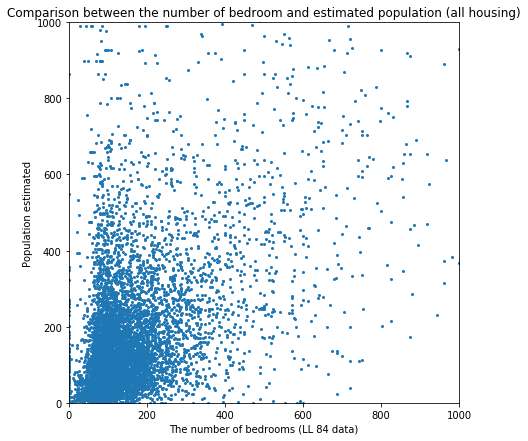

In [45]:
plt.figure(figsize=(7,7))
plt.scatter(result.Bedrooms,result.pop_est_r, s=4)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel("The number of bedrooms (LL 84 data)")
plt.ylabel("Population estimated")
plt.title("Comparison between the number of bedroom and estimated population (all housing)")

In [46]:
result[result['BldgType']=='P'][['BBL', 'ResArea', 'AVG_Water','pop_est_r', 'Bedrooms']]

,BBL,ResArea,AVG_Water,pop_est_r,Bedrooms
5944,3014920001,111200.0,40432.142857,104.0,250.0
5947,1019220041,97918.0,32521.428571,101.0,0.0
5949,1017770005,199884.0,67342.285714,484.0,364.0
5953,2028770001,665000.0,195714.285714,615.0,1359.0
5954,1014450023,105891.0,39832.142857,118.0,95.0
5957,2026260001,127942.0,50925.428571,255.0,312.0
5960,5032430100,382560.0,139088.285714,467.0,884.0
5963,2026960005,114750.0,32457.142857,126.0,238.0
5967,3016360024,114902.0,12660.142857,72.0,150.0
5971,4097610036,122544.0,21010.714286,157.0,93.0


Text(0.5,1,u'Comparison between the number of bedroom and estimated population (NYCHA housing case)')

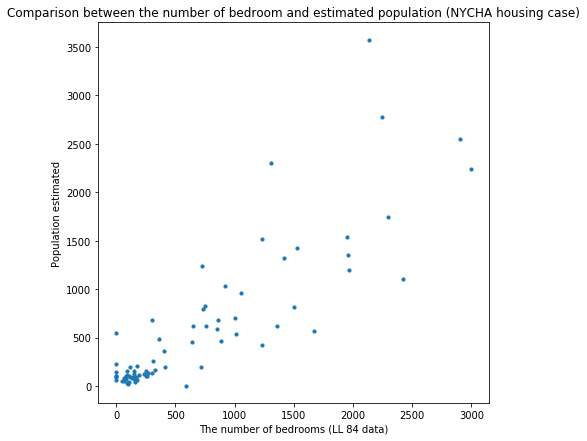

In [47]:
result_public = result[result['BldgType']=='P']
plt.figure(figsize=(7,7))
plt.scatter(result_public.Bedrooms,result_public.pop_est_r, s=10)
plt.xlabel("The number of bedrooms (LL 84 data)")
plt.ylabel("Population estimated")
plt.title("Comparison between the number of bedroom and estimated population (NYCHA housing case)")
#plt.xlim(0,500)
#plt.ylim(0,500)

## 5. Building level population estimation of office buildings
* Local Law 84 (LL84) dataset provided by New York City Mayor’s Office of Sustainability (MOS) including the number of workers on main shift of office buildings over 50,000sqft or city-owned office buildings

In [48]:
ll[['new_bbl', 'Occupancy', 'Office - Gross Floor Area (ft_2)', 'Office - Number of Workers on Main Shift']].head(10)

,new_bbl,Occupancy,Office - Gross Floor Area (ft_2),Office - Number of Workers on Main Shift
0,5012080004,100,2000.0,6.0
1,1012880011,100,NaN,NaN
2,1008680016,100,505775.0,1163.0
3,1008680025,100,351823.0,809.0
4,4034100190,100,NaN,NaN
5,4034100145,100,NaN,NaN
6,2059520374,100,NaN,NaN
7,4001150187,100,NaN,NaN
8,1000560001,100,NaN,NaN
9,3044920004,100,NaN,NaN


In [49]:
print "The number of office buildings with the number of workers information :", len(ll[ll['Office - Number of Workers on Main Shift']>=0])
print "Percentage : ", len(ll[ll['Office - Number of Workers on Main Shift']>=0])/6873.0

The number of office buildings with the number of workers information : 2503
Percentage :  0.364178670159
